In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
import collections
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud

In [ ]:
from sklearn.model_selection import train_test_split

In [2]:
class ProcessData:
    
    df = pd.DataFrame()
    
    def __init__(self):
        self.df = pd.read_csv('../../data/raw/Full_corpus_fromClientFolder.csv')
        
    def readrawdata(self,filename):
        self.df = pd.DataFrame(filename)
    
    def getdataframe(self):
        return(self.df)
    
    def splitdata(self):
        return(train,test)


In [3]:
def display_scores(vectorizer, tfidf_result):
    # http://stackoverflow.com/questions/16078015/
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(tfidf_result.sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    for item in sorted_scores:
        print "{0:50} Score: {1}".format(item[0], item[1])

#display_scores(tfidf_vec,full_tfidf)

In [4]:
model = ProcessData()
df = model.getdataframe()
columns = ['Unnamed: 0']
df.drop(columns,inplace=True,axis=1)

###### unique category values
df.cat.unique() 
['Insurance/Disability', 'Hospitalization', 'Billing', 'Employment',
       'Military', 'NRLs'] 

###### unique sub-category values
df.subcat.unique()
['Insurance/DisabilityCorrespondence', 'LaboratoryReports', nan,
       "Nurses' Notes/Telephone Logs", 'EmergencyRoomRecord',
       'CardiacData', 'Physicians/Orders', 'Consents', 'Correspondence']

In [6]:
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
full_tfidf = tfidf_vec.fit_transform(df['content'].values.tolist())

Xtr = tfidf_vec.fit_transform(df['content'])
features = tfidf_vec.get_feature_names()

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        identified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=50):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

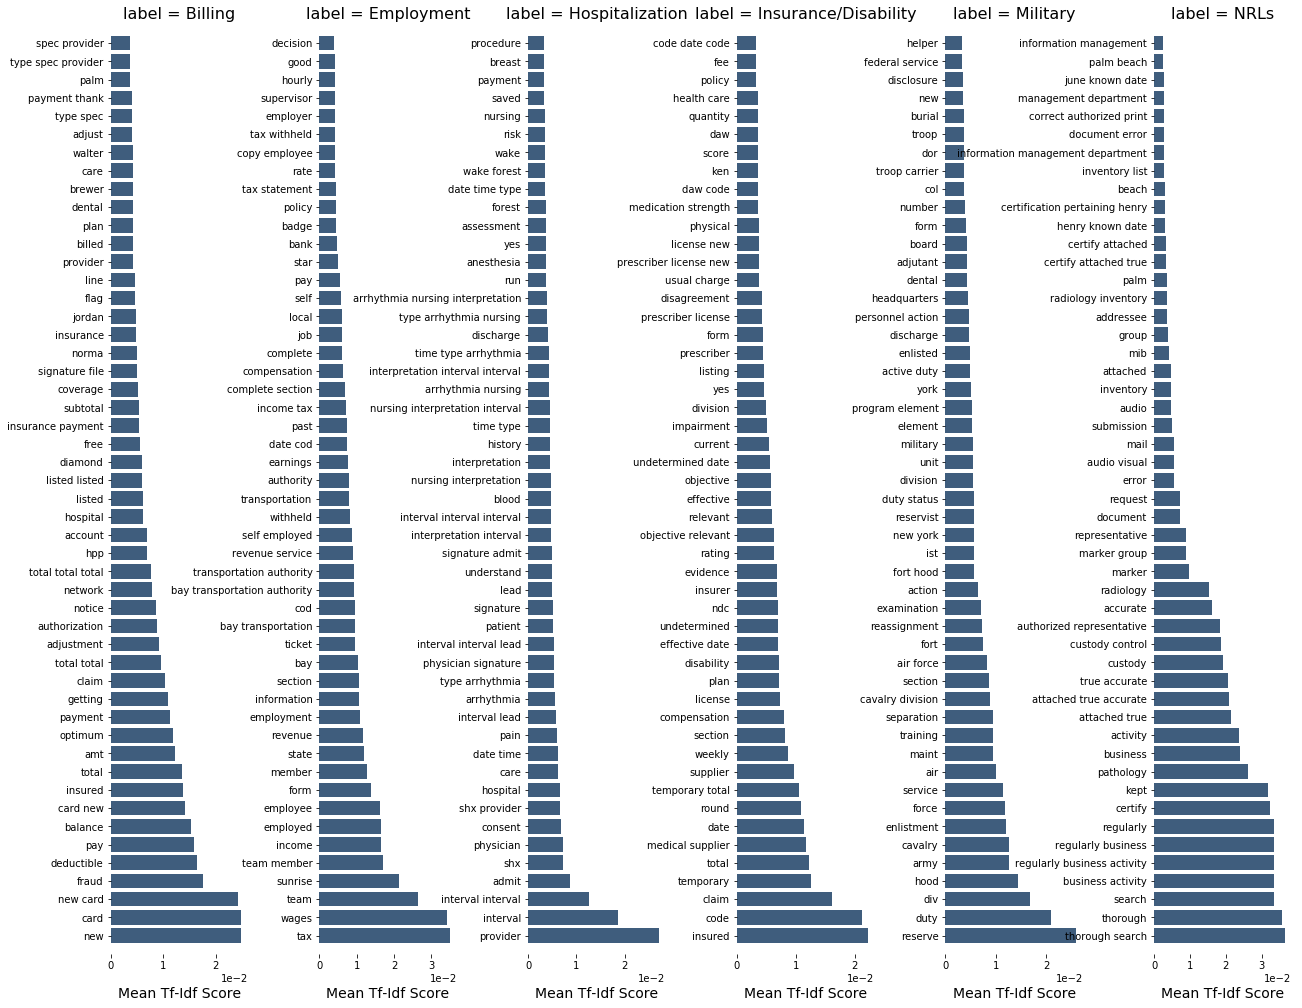

In [7]:
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(20, 15), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):         
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

y = df['cat']
plot_tfidf_classfeats_h(top_feats_by_class(Xtr,y,features))

/home/jayap/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jayap/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


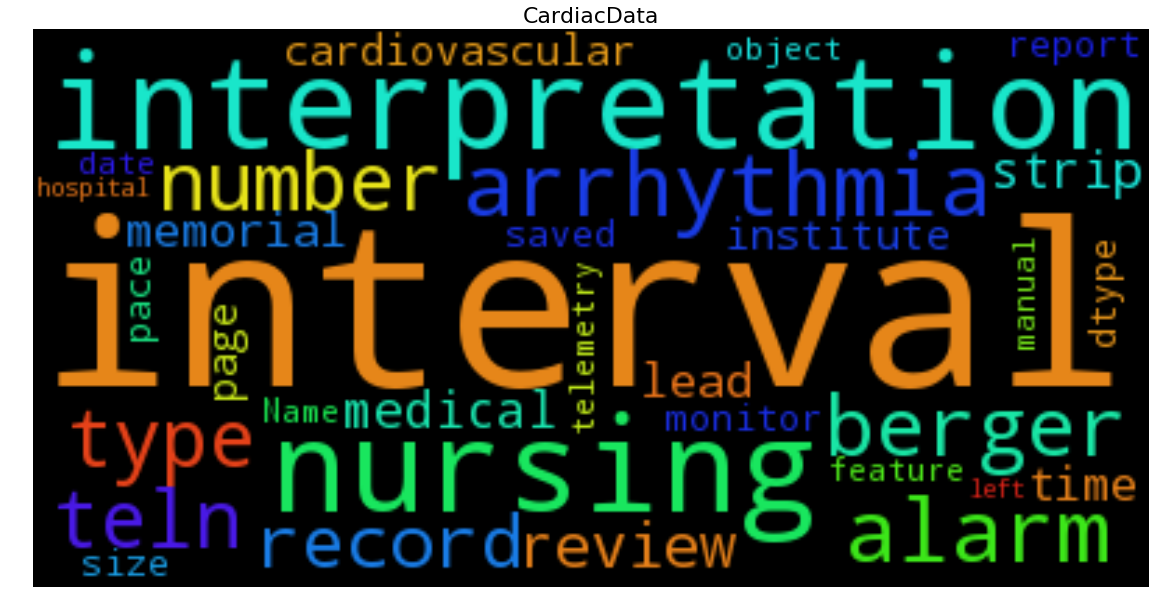

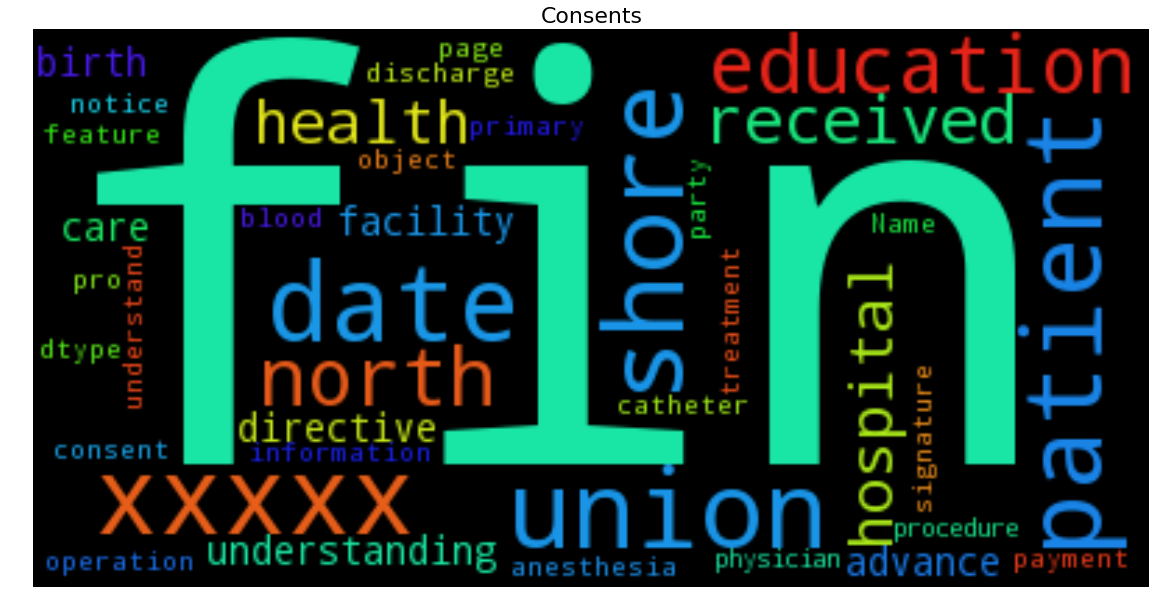

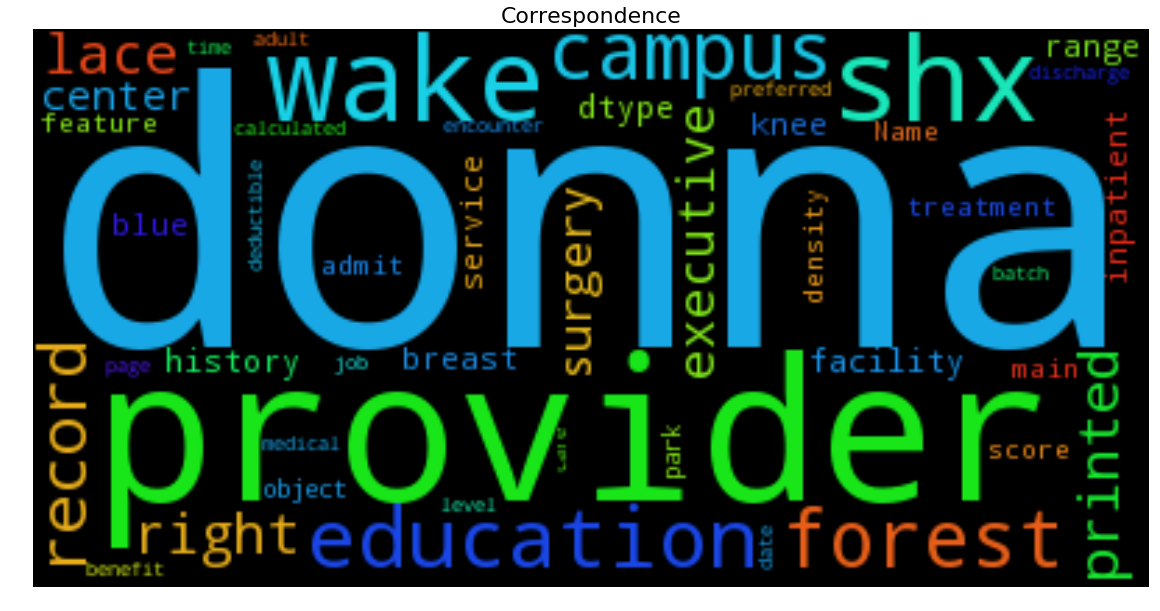

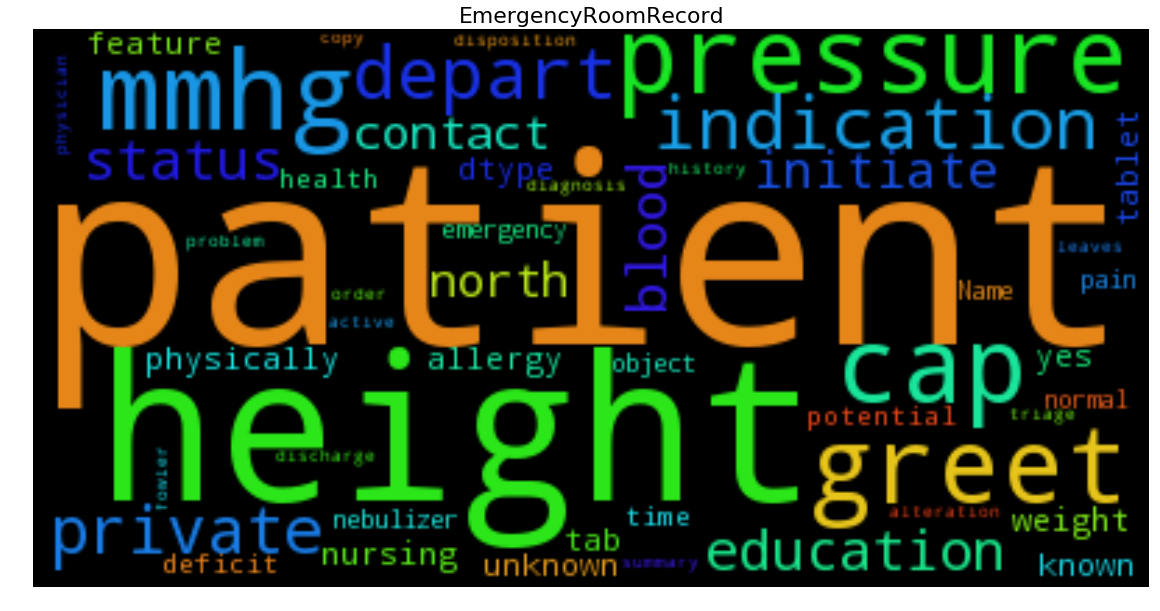

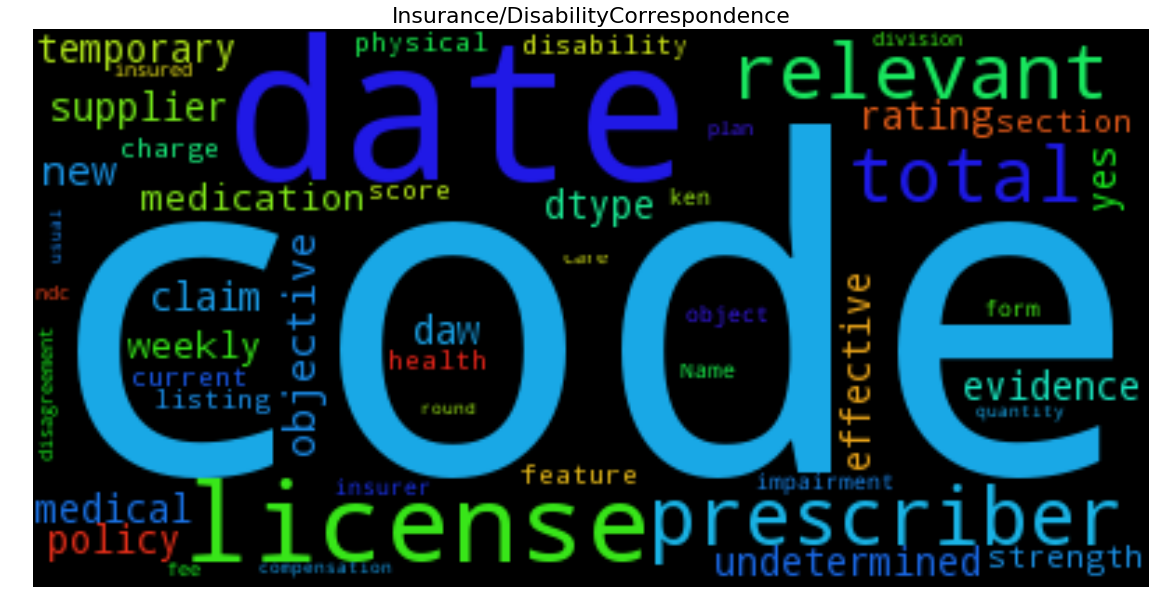

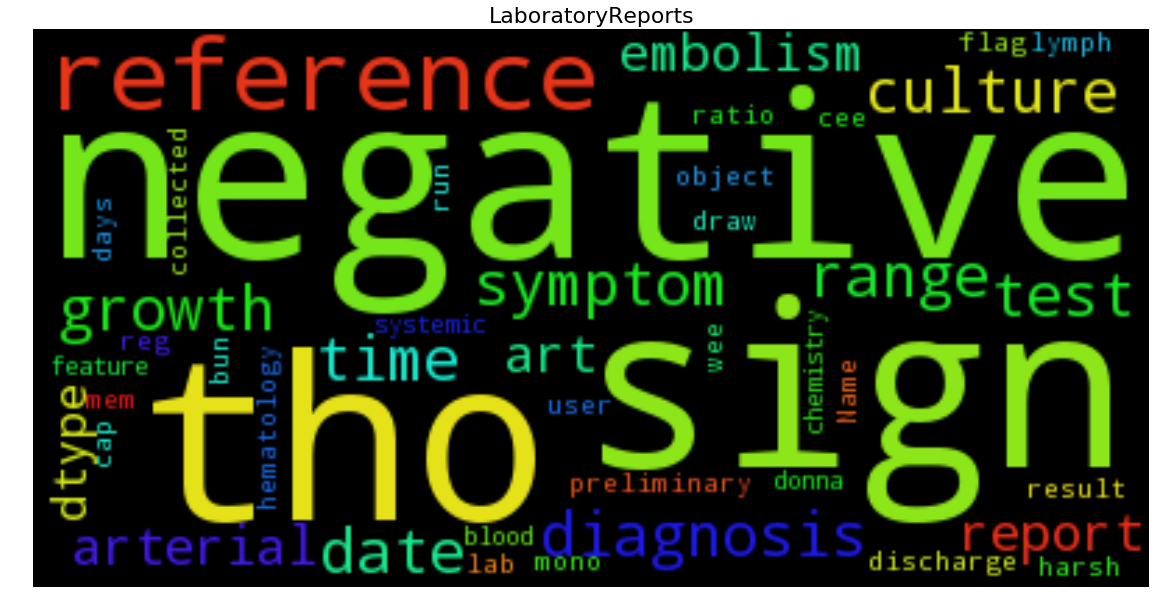

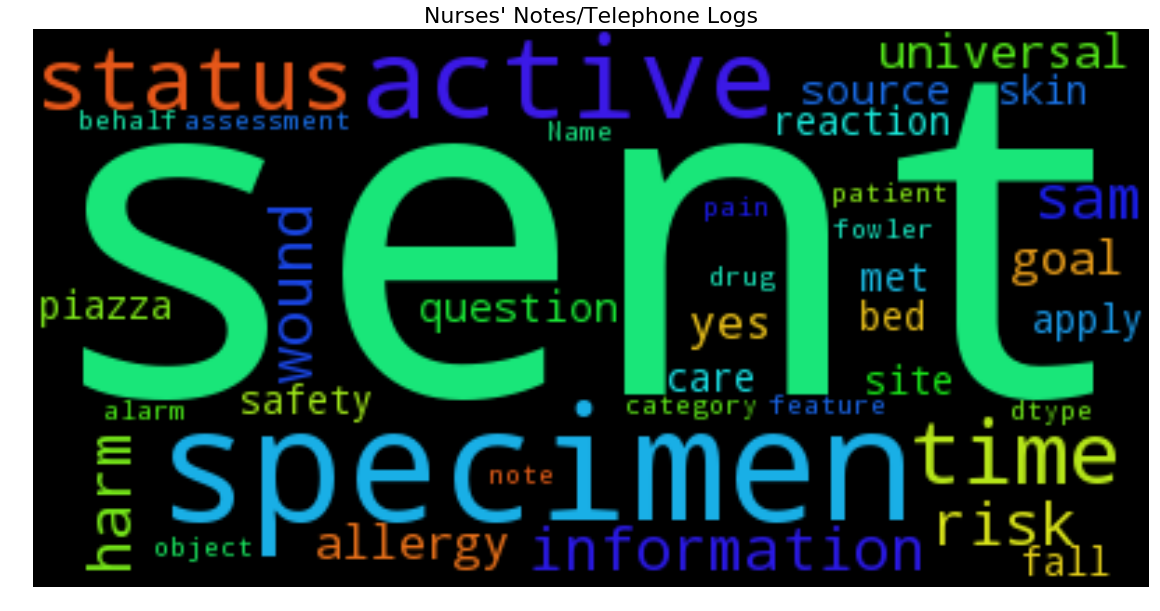

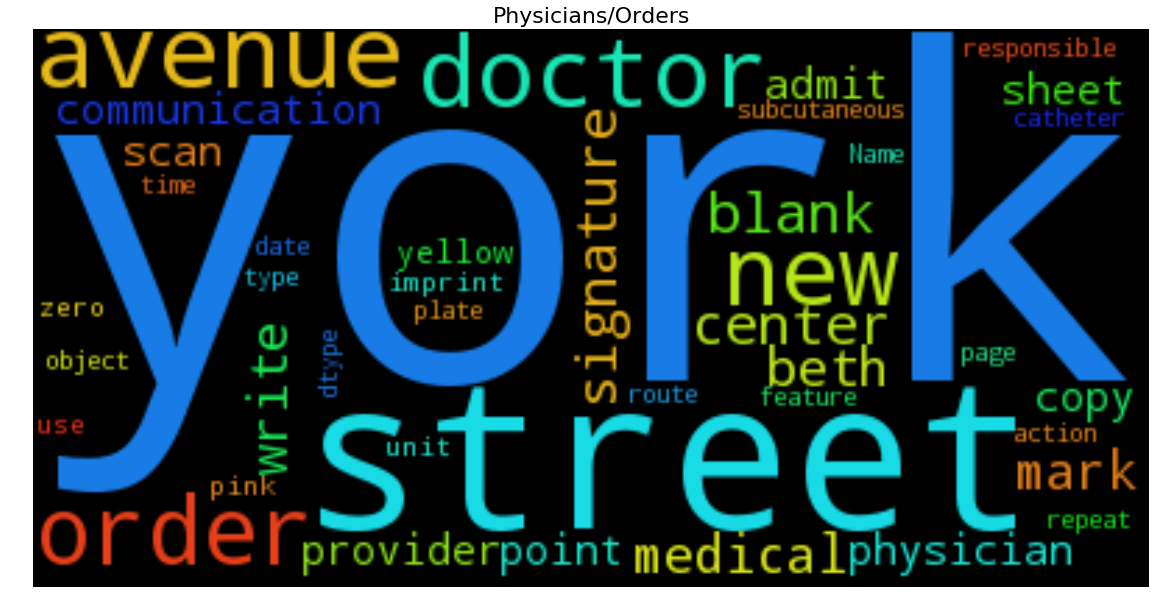

In [8]:
def wordcloud_classfeats_h(dfs):
    
    for i, df in enumerate(dfs):
        if (str(df.label) != 'nan'):
            wordcloud = WordCloud().generate(str(df.feature))
            plt.figure(figsize=(20, 15))         
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis("off")
            plt.title(str(df.label), fontsize=22)
            plt.savefig('tf-idfWordCloud_SubCatLabels'+'-'+df.label.split('/')[0])
        plt.show()

y = df['subcat']
wordcloud_classfeats_h(top_feats_by_class(Xtr,y,features))

In [ ]:
new_df.to_csv("/home/jayap/labellingrecordproject/data/processed/processed_corpus.csv")

Before cleaning - The maximum and minimum words for each page is 1189,7
After removing the stopwords, punc and non-english words, the max,min words in the content - 532, 4

The number of pages of each document - 'no_pages', max - 13 min -1

In [ ]:
new_df.drop(new_df[new_df['no_words'] < 25].index,inplace=True)

In [ ]:
def plotEachGroup(name):    
     
    fig, ax = plt.subplots()
    grouped = new_df[['cat','subcat']].groupby(['cat'])
    subgrp = grouped.get_group(name,)
    if(subgrp.nunique()[1]>0):
        subgrp.groupby('subcat').count().plot(kind='bar',ax=ax)
    else:
        subgrp.count().plot(kind='bar',ax=ax)
    L=plt.legend()
    L.get_texts()[0].set_text(name)
    plt.show()



In [ ]:
for lab in new_df.cat.unique():
    plotEachGroup(lab)